In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from latent_geometry.model.mnist_vae import load_decoder, load_encoder
from latent_geometry.data import load_mnist_dataset
from optim_summary import (
    optimize,
    summarize_path,
    create_summary_fig,
    run,
    run_setup,
    main,
)
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from torch.optim import SGD

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [4]:
dataset = load_mnist_dataset("train")
imgs = torch.concatenate([img for img, label in dataset]).cuda()
imgs.shape

torch.Size([60000, 32, 32])

In [5]:
DEVICE = torch.device("cuda")
model_name, latent_dim = "latent_8_dim_beta_10", 8

ENCODER = load_encoder(DEVICE, f"{model_name}_encoder.pt", latent_dim=latent_dim)
DECODER = load_decoder(DEVICE, f"{model_name}_decoder.pt", latent_dim=latent_dim)

# z = ENCODER.sample(dataset[0][0].to(DEVICE)[None, :])
# reconstruction = DECODER.decode(z)
# reconstruction.shape

In [6]:
with torch.no_grad():
    zs = ENCODER.encode(imgs[:, None, ...])
zs.shape

torch.Size([60000, 8])

In [7]:
from typing import Union


def show_digits(
    zss: list[Union[tuple[torch.Tensor, ...], torch.Tensor]], names: list[str] = None
):
    fig, axs = plt.subplots(1, len(zss), figsize=(16, 4))
    for i, zs in enumerate(zss):
        xs = []
        if not isinstance(zs, tuple):
            zs = (zs,)
        for z in zs:
            with torch.no_grad():
                x = DECODER.decode(z).cpu().numpy().reshape(32, 32)
            xs.append(x)
        img = np.concatenate(xs, axis=0)
        ax = axs[i] if len(zss) > 1 else axs
        ax.imshow(img, vmin=0, vmax=1)
        if names:
            ax.set_title(
                names[i],
                fontsize=8,
            )
        ax.set_axis_off()

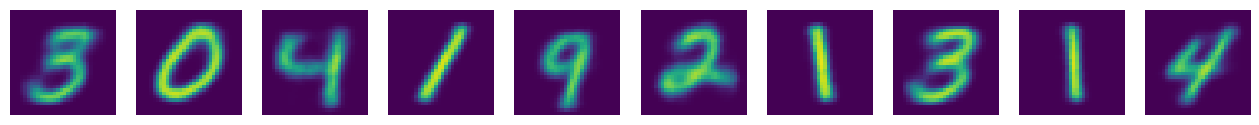

In [8]:
show_digits(zs[:10])

In [40]:
# SETUP = [("standard", 0.1), ("geometric", 0.1), ("retractive", 0.1)]
SETUP = [
    ("retractive", 0.5),
    ("standard", 0.1),
]

In [41]:
with torch.no_grad():
    TARGET_3 = DECODER.decode(zs[[7]]).reshape(32, 32)

In [42]:
TARGET_3.requires_grad

False

In [43]:
darkness = ("darkness", lambda x: 1 - x.mean(), 1.0)
brightness = ("brightness", lambda x: x.mean(), 1.0)
entropy = ("entropy", lambda x: -x.log().mean(), 0.05)
neg_entropy = ("negative entropy", lambda x: x.log().mean(), 0.05)
threeness = ("threeness", lambda x: ((x - TARGET_3) ** 2).mean().sqrt(), 0.5)

In [51]:
img = run(
    zs[[21]],
    n_iter=1000,
    loss=(brightness[0], brightness[1]),
    map_fn=DECODER.decode,
    optim_setup=SETUP,
)

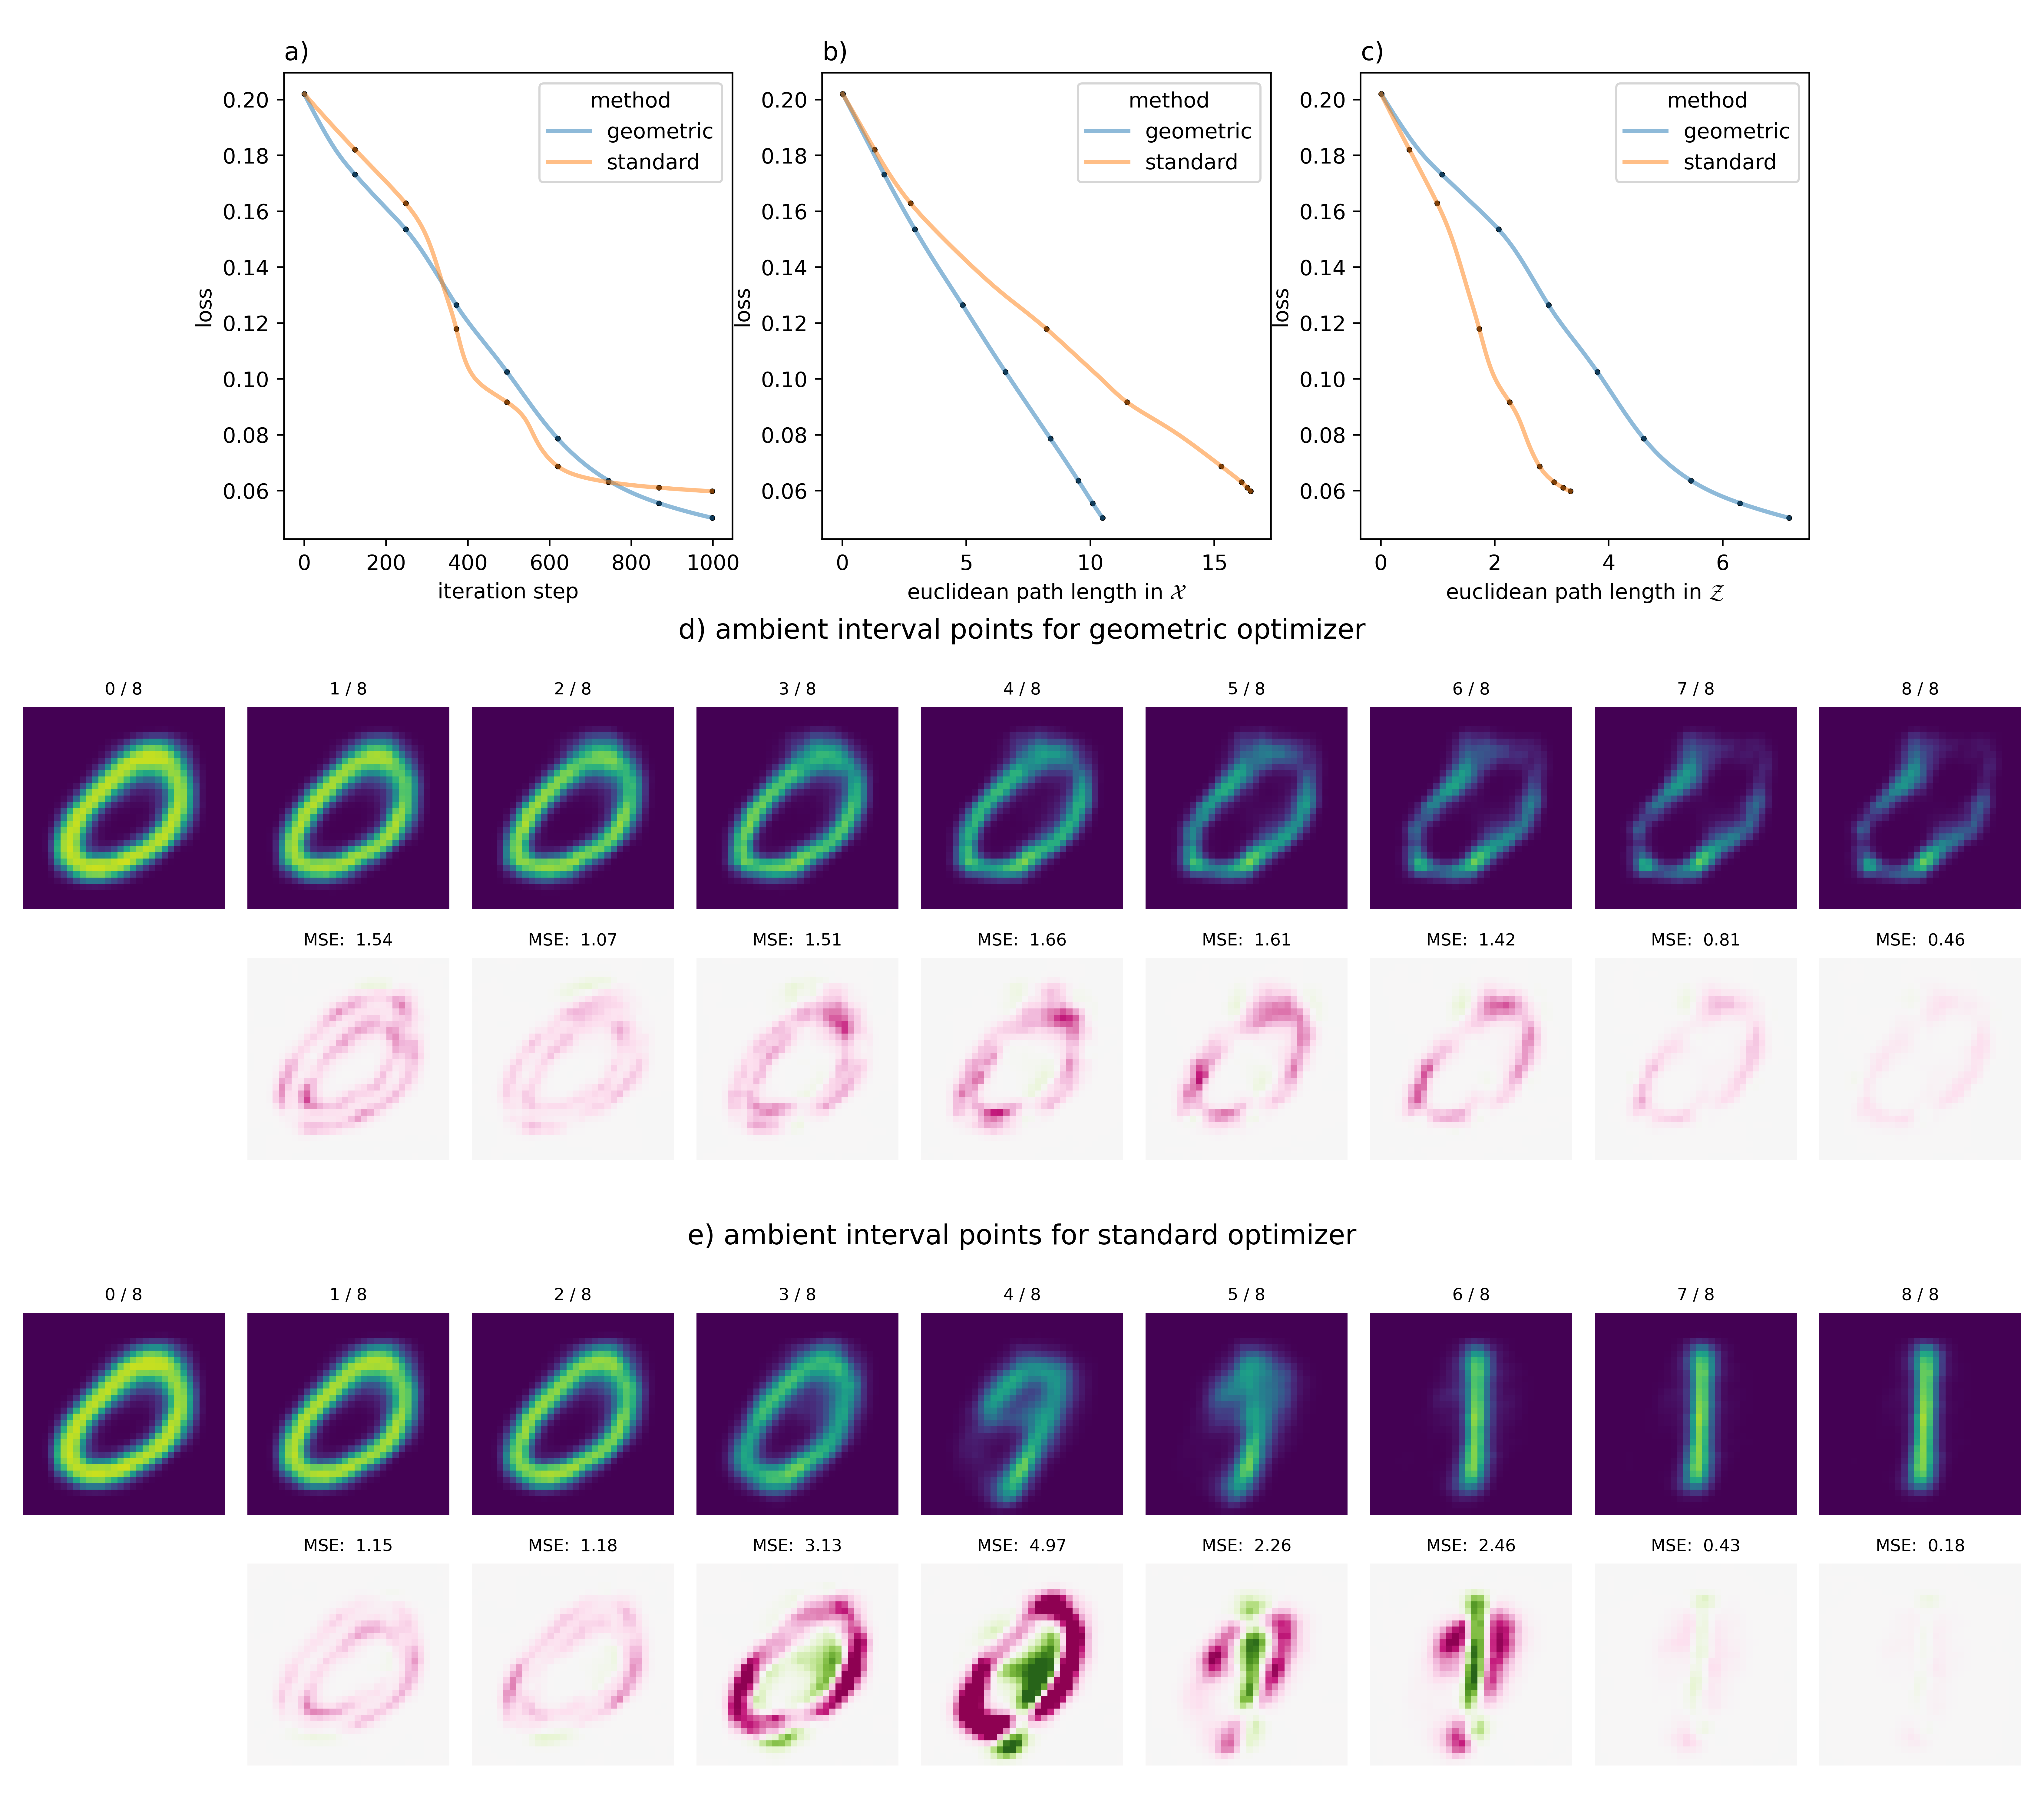

In [52]:
img

In [53]:
from latent_geometry.config import FIGURES_DIR

img.save(FIGURES_DIR / "mnist" / "images" / "mgr" / "optim_8dim.png")

In [15]:
# main(
#     model_name="latent_8_dim_beta_10",
#     latent_dim=8,
#     n_iter=1_000,
#     optim_setup=SETUP,
#     losses=[darkness, brightness, entropy, neg_entropy, threeness],
#     tag="zs_0_100",
#     points=zs[:100].unsqueeze(1),
# )